# Exercício 6

In [65]:
import numpy as np
import matplotlib.pyplot as plt 
import time 

## Definição da rede


### Função de definição da rede

In [66]:
def GeraRede(nx,ny,CH,CV):
    nv = nx*ny
    nc = (nx-1)*ny + (ny-1)*nx
    
    conec = np.zeros(shape=(nc,2),dtype=np.int64)
    C = np.zeros(nc)
    
    # Loop sobre canos horizontais
    for j in range(ny):
        for i in range(nx-1):
          k = j*(nx-1) + i
          conec[k,0] = j*nx + i
          conec[k,1] = j*nx + i+1
          C[k] = CH

    # Loop sobre canos verticais
    for i in range(nx):
      for j in range(ny-1):
          k = (nx-1)*ny + j*nx + i
          conec[k,0] = i + j*nx
          conec[k,1] = i + (j+1)*nx
          C[k] = CV

    return nv, nc, conec, C

## Funções de plotagem da Pressão

In [67]:
def PlotPressure(nx, ny, pressure):
    x = np.arange(0, nx, 1)
    y = np.arange(0, ny, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (ny,nx)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    cp = plt.contourf(X, Y, Z, cmap='jet')
    cb = plt.colorbar(cp)
    plt.show()

def PlotPressureAsSurface(nx, ny, pressure):
    x = np.arange(0, nx, 1)
    y = np.arange(0, ny, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (ny,nx)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax = plt.axes(projection="3d")
    ax.plot_surface(X, Y, Z, cmap='jet', edgecolor=None)
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(elev=30., azim=45)
    plt.show()

## Funções Pŕevias

### 1- Monta matriz conduc e matriz A

In [68]:
def retorna_conduc(C):
    tam=len(C)
    conduc=np.zeros(shape=(tam,tam),dtype=np.float64)
    for i in range(tam):
        conduc[i][i]=C[i]
    return conduc


def retorna_matriz_A(conec,nc,nv,conduc):
    #Inicia a matriz A que será retornada
    A=np.zeros(shape=(nv,nv),dtype=np.float64)
    
    n1,n2=0,0

    for i in range(nc): # percorre as linhas da matriz de conecções
        
        #recebimento dos nós da linha i da matriz de conecções
        n1,n2=conec[i][0],conec[i][1]

        # adição de elementos conforme a matriz ClocK
        A[n1][n1]=A[n1][n1]+conduc[i][i]    
        A[n1][n2]=A[n1][n2]-conduc[i][i]
        A[n2][n1]=A[n2][n1]-conduc[i][i]
        A[n2][n2]=A[n2][n2]+conduc[i][i]
                        
    
    return A

### 2-Função de formação da matriz Ã e matriz direita

In [69]:

def retorna_matriz_Ã(A,natm):
    rng=len(A[0])
    Ã=A
    for i in range(0,rng):
        if(i==natm):
            Ã[natm][i]=1
        else:
            Ã[natm][i]=0
    return Ã

def retorna_matriz_direita(nv,nB,QB):
    d=np.zeros(nv,dtype=np.float64)
    for i in range(0,nv):
        if(i==nB): d[i]=QB
        else: d[i]=0
    return d



### 3-Função de resolução do sistema e de vazões nodais

In [70]:
def retorna_pressoes(Ã,d):
    #Obtém a matriz Inversa da matriz Ã
    I=np.linalg.inv(Ã)

    #Obtém vetor de pressões
    P=I@d
    return P

def vetor_vazoes_nodos(A,P):
    Q=A@P
    return Q

### 4-Obtenção do vetor de vazões nos canos e da potência da bomba

In [71]:
def retorna_vazoes_canos(conduc,D,P):
    Qc=conduc@D@P
    W=(Qc.transpose())@(D@P)
    return Qc,W

### 5-Obtenção da matriz D 

In [72]:
def retorna_matriz_D(nc,nv,conec):
    l=nc
    c=nv
    D=np.zeros(shape=(l,c),dtype=np.float64)
    for i in range(l):
        n1,n2=conec[i][0],conec[i][1]
        D[i][n1]=1
        D[i][n2]=-1
    return D

### 6-Resolve o sistema

In [73]:
def resolve_sistema(natm,nB,QB,nv,nc,conec,conduc):
    A=retorna_matriz_A(conec,nc,nv,conduc)
    Ã=retorna_matriz_Ã(A,natm)
    d=retorna_matriz_direita(nv,nB,QB)
    P=retorna_pressoes(Ã,d)
    return P
   

## Análise de tempos de resolução em função de Nv=m*n

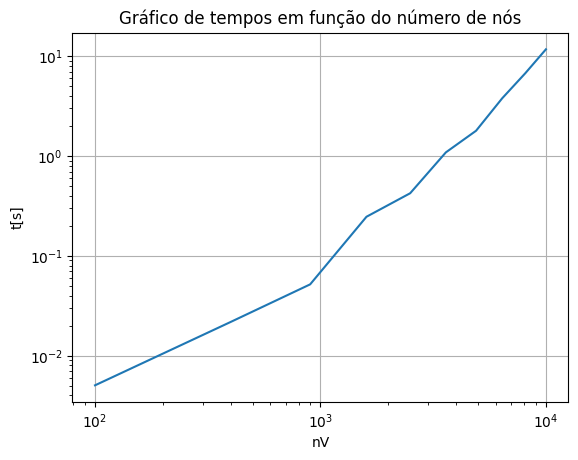

In [74]:
#   Pré-setagem
CH=1.3
CV=3.6
nB=0
QB=3

#   Função que calcula o tempo de processamento de resolução do sistema
def tempo_de_processo(natm,nB,QB,nv,nc,conec,C):
    conduc=retorna_conduc(C)
    ti=time.time()
    P=resolve_sistema(natm,nB,QB,nv,nc,conec,conduc)
    tf=time.time()-ti
    return tf

#   Vetor com os índices m e n (nx e ny) referentes a rede grade
indices=np.linspace(1,10,10,dtype=np.int64)*10

#   Vetores de plotagem
x=indices**2
y=np.array([],dtype=np.float64)

#   Laço cujo indice i indica qual elemento do vetor indice ocupará a posição de m e n na função
#de cálculo do tempo de resolução do sistema relacionado à rede
for i in range (0,len(indices)):
    nv, nc, conec, C = GeraRede(indices[i],indices[i],CH,CV)
    y=np.append(y,tempo_de_processo((indices[i]**2)-1, nB, QB, nv, nc, conec, C))
 

plt.loglog(x,y)
plt.grid()
plt.title('Gráfico de tempos em função do número de nós')
plt.xlabel('nV')
plt.ylabel('t[s]')
plt.show()

    



## 